In [37]:
%load_ext jupyternotify

import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
matplotlib.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")
sys.path.insert(0, "../utils")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import TSPN
import PollingSystem as PS
import MarkovianRP as MRP
import StaticRP as SRP
import dtr
import motion
import shot_solvers as SHOT

import sim_template as sim
from importlib import reload 

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [2]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 8#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-71.8297512825111
SNR Threshold: 33


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


[16.0, 46.0] [34.0, 46.0]
[2.2466602084272504, 22.929848235217513] [7.808966107176305, 40.04886552853028]
[19.93766265123259, 2.720575847493845] [5.375356752483535, 13.300710388758363]
[44.62464324751646, 13.300710388758358] [30.0623373487674, 2.7205758474938433]
[42.191033892823704, 40.04886552853027] [47.75333979157275, 22.92984823521751]
0.0625
[2.4, 0.16, 0.16, 0.16, 0.16, 0.16]


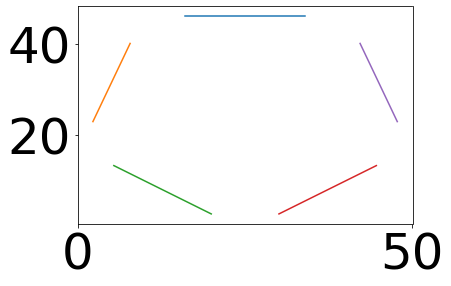

In [3]:
#Setup the communication environment:

#For now, use same channel params
nPL = 5.2
kPL = -20

decorrSH = 2.09  
alpha = 16
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1.5


#12 remote stations
rad = 21
le=18
center = [25, 25]
def gen_bs(c, r, l,  theta):
    #rotate 90 degrees
    field_center = [-r*np.sin(theta)+c[0], r*np.cos(theta)+c[1]]
    bs1 = [-1*(l/2)*np.sin(-(theta-np.pi/2))+field_center[0], (l/2)*np.cos(-(theta+np.pi/2))+field_center[1]]
    bs2 = [-1*(l/2)*np.sin(-(theta+np.pi/2))+field_center[0], (l/2)*np.cos(-(theta-np.pi/2))+field_center[1]]
    return bs1, bs2

qBase = [[15, 25],[35,25]]
for i in range(5):
    theta = i*2*np.pi/5
    b1, b2 = gen_bs(center, rad, le, theta)
    print(b1, b2)
    qBase.append(b1)
    qBase.append(b2)
    plt.plot([b1[0], b2[0]],[b1[1], b2[1]])
qBase = np.array(qBase)

sub_regions = [[40,10, 30,20],
               [40,10, 50, 40],
               [15,0, 46, 17],
               [26, 0, 19,0],
               [50, 25, 19, 0],
               [50, 35, 46, 17]]


x_max = 50
x_min = 0
y_max = 50
y_min = 0
region = [x_max, x_min, y_max, y_min]


cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]



#res = 2/decorrMP
res = 10
n = 6
p_th = 0.5

#Polling System Setup
bandwidth = 2#leave bandwidth in MHz*1000000#give ourselfes 2MHz of BW
beta = 1/(r*bandwidth)
print(beta)
els = [0.15/beta, 0.01/beta, 0.01/beta, 0.01/beta, 0.01/beta, 0.01/beta]
print(els)

In [4]:
reload(sim)
ccs, cfs, true_joint_con_fields, tjcps = sim.create_channels(cps, region, res, GAMMA_TH, sub_regions)

Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing genera

In [5]:
reload(sim)
pcs, pfs, pjcps, prob_pred_con = sim.predict_channels(res, ccs, true_joint_con_fields, GAMMA_TH, p_th=p_th)
trismall_pcs = pcs

print(prob_pred_con)

Drawing 300 samples from Channel 1
Completed PredictedChannel 1
Drawing 300 samples from Channel 2
Completed PredictedChannel 2
Drawing 300 samples from Channel 3
Completed PredictedChannel 3
Drawing 300 samples from Channel 4
Completed PredictedChannel 4
Drawing 434 samples from Channel 5
Completed PredictedChannel 5
Drawing 434 samples from Channel 6
Completed PredictedChannel 6
Drawing 494 samples from Channel 7
Completed PredictedChannel 7
Drawing 494 samples from Channel 8
Completed PredictedChannel 8
Drawing 475 samples from Channel 9
Completed PredictedChannel 9
Drawing 475 samples from Channel 10
Completed PredictedChannel 10
Drawing 434 samples from Channel 11
Completed PredictedChannel 11
Drawing 434 samples from Channel 12
Completed PredictedChannel 12
[0.8, 0.5, 0.75, 0.8238255033557047, 0.8283062645011601, 0.6049149338374291]


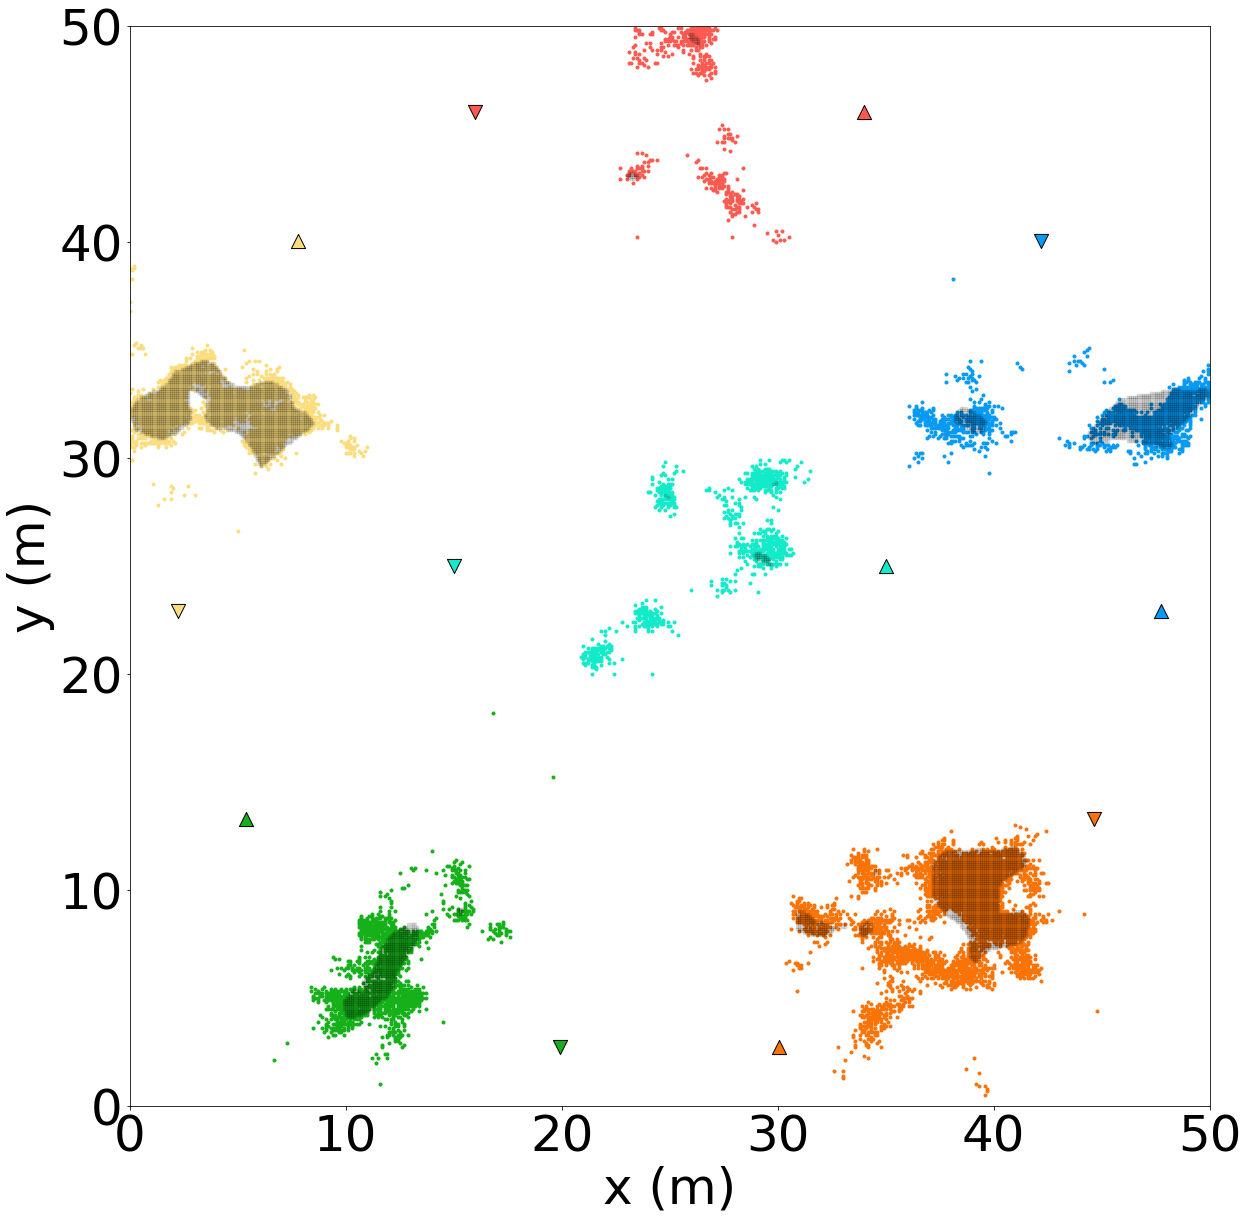

In [6]:
reload(sim)
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.gca().invert_yaxis()
plt.show()

Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
Info: Reduced Poly only contains two points. Reduction ignored
Poly: ([29.9 28.9])  ([29.8 28.8])  ([29.9 28.8]) Is Interior: False
3 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
3 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
Point: [ 8.50006247 31.59992191]
Poly: ([ 8.1 32.1])  ([ 8.5 31.6])  ([ 7.3 33.1]) Is Interior: False


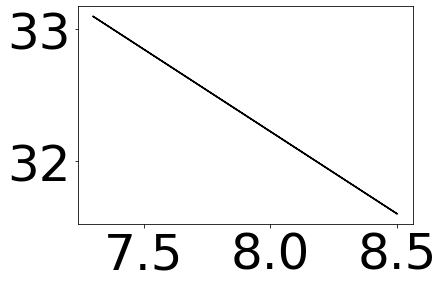

12 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
4 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 5 possibly non-convex polygons
Info: Reduced Poly only contains two points. Reduction ignored
Poly: ([34.6 10.8])  ([34.6 10.9])  ([34.5 10.9])  ([34.5 10.8]) Is Interior: False
16 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
Point: [44.69992929 31.50007071]
Poly: ([44.4 31.2])  ([44.7 31.5])  ([45.9 32.7]) Is Interior: False


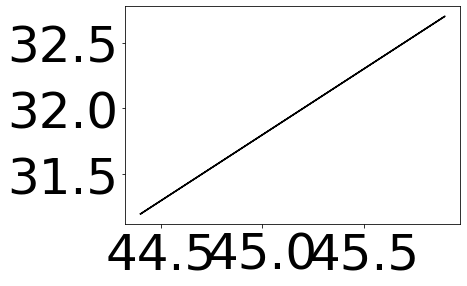

7 total subregions


In [7]:
#setup the delay-tolerant relay system
reload(dtr)
dt_sys = dtr.DTR(pcs, region, els, beta, th=GAMMA_TH, p_th = p_th)

Total of 60 Permutations to Try
Working on Permutation (0, 1, 2, 3, 4, 5)
Optimal Solution Improved to 105.80
Working on Permutation (0, 1, 2, 3, 5, 4)
skiping based on lower bound
Working on Permutation (0, 1, 2, 4, 3, 5)
skiping based on lower bound
Working on Permutation (0, 1, 2, 4, 5, 3)
skiping based on lower bound
Working on Permutation (0, 1, 2, 5, 3, 4)
skiping based on lower bound
Working on Permutation (0, 1, 2, 5, 4, 3)
skiping based on lower bound
Working on Permutation (0, 1, 3, 2, 4, 5)
skiping based on lower bound
Working on Permutation (0, 1, 3, 2, 5, 4)
skiping based on lower bound
Working on Permutation (0, 1, 3, 4, 2, 5)
skiping based on lower bound
Working on Permutation (0, 1, 3, 4, 5, 2)
skiping based on lower bound
Working on Permutation (0, 1, 3, 5, 2, 4)
skiping based on lower bound
Working on Permutation (0, 1, 3, 5, 4, 2)
skiping based on lower bound
Working on Permutation (0, 1, 4, 2, 3, 5)
skiping based on lower bound
Working on Permutation (0, 1, 4, 2, 5,

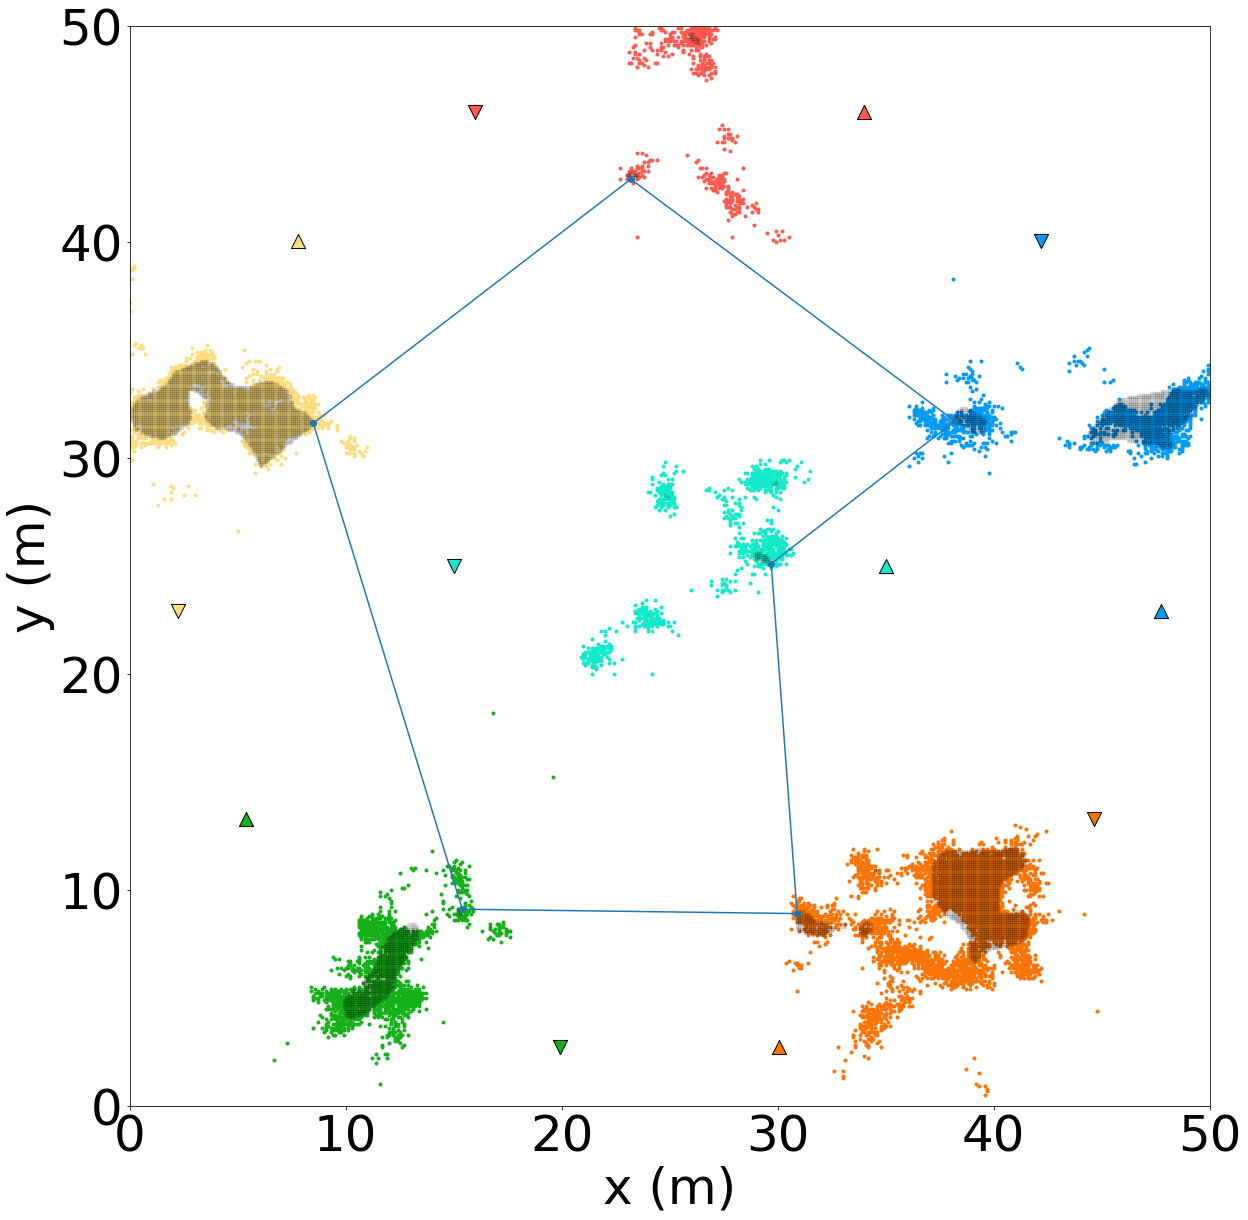

In [8]:
reload(sim)
regions = dt_sys.cregions
tspn_min, tspn_argmin = TSPN.TSPN_BF(regions)
x=tspn_argmin[0]

TSPNP={'X':x, 'SEQ':tspn_argmin[1]}

order = list(tspn_argmin[1])
order.append(0)#complete the loop
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.plot(x[order,0], x[order,1], zorder=100)
plt.scatter(x[:,0], x[:,1], zorder = 100)
plt.gca().invert_yaxis()
plt.show()

In [31]:
reload(sim)
v = 1
#manuallt reset els if needed
els = [0.3/beta, 0.02/beta, 0.03/beta, 0.02/beta, 0.01/beta, 0.02/beta]
ps = dt_sys.ps
ps.Ls = np.array(els)

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 35})

print("Finding AORP")
AORP = sim.calc_AORP(dt_sys, v)
print("Found AORP")
pi = AORP['pi']
S = dtr.XtoS(AORP['X'])
S_cy = dtr.XtoS(TSPNP['X'])
S_cyv = np.zeros(n)
seq = TSPNP['SEQ']
for i in range(n):
    S_cyv[i] = S_cy[seq[i], seq[(i+1)%n]]

#S_i = S @ pi
W_rnd = ps._calc_avg_wait_random(S, pi)
W_cy = ps._calc_avg_wait_cyclic(S_cyv)

#print(S)
P_tilde, pi_tilde = sim.pi_to_P(pi)
print(P_tilde)
S_i = np.diag(P_tilde@S)
print(els)
print(pi)
print(pi_tilde)
print(S_i)
print(W_rnd)
print(W_cy)

Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
[[0.         0.21077191 0.21055467 0.15717017 0.13218122 0.28932203]
 [0.87864485 0.         0.0323758  0.02416717 0.02032476 0.04448742]
 [0.8786155  0.03240812 0.         0.02416636 0.02032408 0.04448593]
 [0.87146223 0.03214427 0.03211114 0.         0.02015861 0.04412375]
 [0.86815369 0.03202224 0.03198923 0.02387861 0.         0.04395623]
 [0.88938705 0.03280544 0.03277163 0.02446264 0.02057325 0.        ]]
[4.8, 0.32, 0.48, 0.32, 0.16, 0.32]
[0.85106259 0.03139182 0.03135947 0.02340852 0.01968673 0.04309087]
[0.46784952 0.11222912 0.11211719 0.08437771 0.07123268 0.15219377]
[16.65024752 16.61639655 22.05152148 24.94459993 19.60317102 10.70508656]
78.2387148519681
64.909560890118


In [35]:
reload(sim)
hrs = 2
mins = 0
seconds = 0
print('Velocity = %f'%(v))
motion_power = motion.LinearMotionPower(7.2, 0.29, v)
sim.run_sims(dt_sys.ps, AORP, TSPNP, hrs, mins, seconds, motion_power, MOBILE_TX_POWER.W, v)
print('done')

Velocity = 1.000000
Theotretical MB serviced: 46080.0
Theoretical Energy Consumption (J): 32644.8
	Th. WT	WT	E (J)	MBS	MBR
AORP	78.24	73.08	32960.83	45463.00	530.20
Tab	---	53.00	32844.78	45718.10	364.90
TSPN	---	66.13	32825.27	45717.15	390.70
done


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

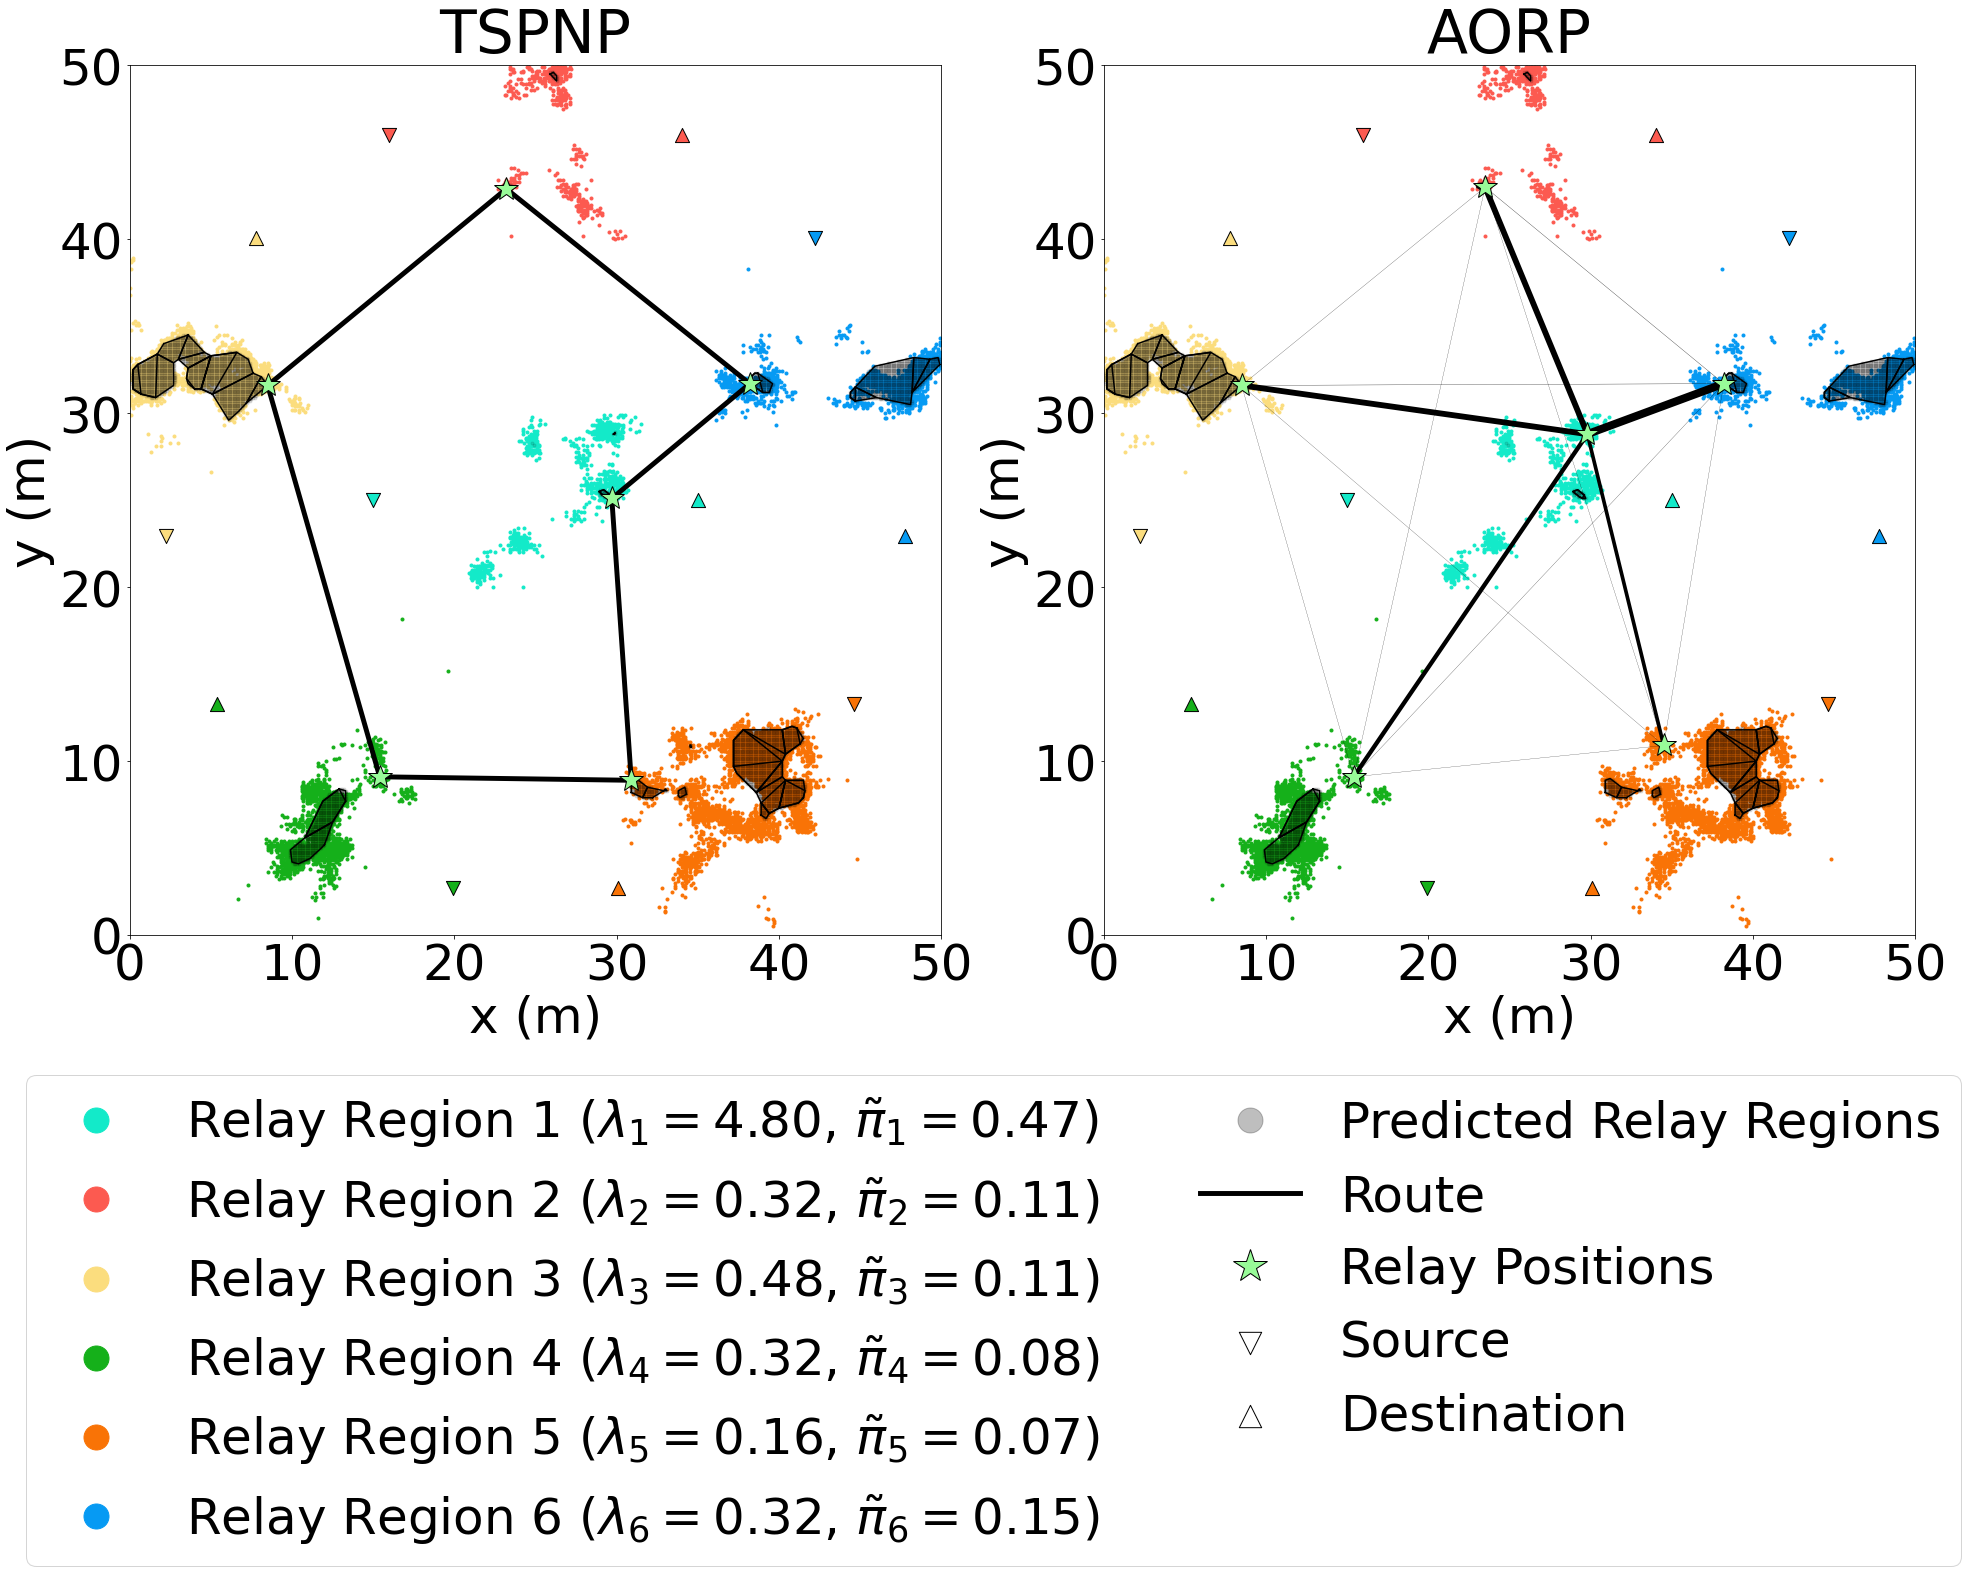

In [34]:
reload(sim)
sim.plot_AORP_W_TSPN(dt_sys, AORP, TSPNP, tjcps, pjcps, qBase, region, els, AORP['pi'])

plt.savefig("six_star_TSPNP_v_AORP.png", format='png', bbox_inches='tight')
plt.savefig("six_star_TSPNP_v_AORP.eps", format='eps', bbox_inches='tight')

In [42]:
#now look for trends
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 35})
v = 1
S_cy = dtr.XtoS(TSPNP['X'])
S_cyv = np.zeros(n)
seq = TSPNP['SEQ']
for i in range(n):
    S_cyv[i] = S_cy[seq[i], seq[(i+1)%n]]
    
    
W_aorp = []
W_tab = []
W_tspnp = []
s_tilde = []
dispersion = []


scales = np.array([0.005, 0.01, 0.5, 1, 5, 10, 20, 30])
d = len(scales)
vals = np.tile(np.ones(n), (d,1))
vals[:,0]*=scales

sys_traffic = 0.3
L_S = sys_traffic/beta


for val in vals:
    #normalize
    val = (val/np.sum(val))*L_S
    print(val)
    ps.Ls = val
    print("Finding AORP")
    AORP = sim.calc_AORP(dt_sys, v)
    print("Found AORP")
    pi = AORP['pi']
    S = dtr.XtoS(AORP['X'])
    
    #also look at the tabular version
    rtable = SRP.SRPFromPis(pi, eps=0.01)
    seconds = 2*60*60
    xt, wt, queues, total_travel_time, _, _, _ = ps.simulate(rtable, S, seconds)
    W_tab.append(wt[-1][1])
    #S_i = S @ pi
    W_rnd = ps._calc_avg_wait_random(S, pi)
    W_aorp.append(W_rnd)
    W_cy = ps._calc_avg_wait_cyclic(S_cyv)
    W_tspnp.append(W_cy)

    P_tilde, pi_tilde = sim.pi_to_P(pi)
    S_obs = pi_tilde.T @ (S*P_tilde) @np.ones((n,1))
    s_tilde.append(S_obs)
    
    X = AORP['X']
    X_avg = np.average(X,0, weights=val)
    diffs = X - X_avg
    dists = np.linalg.norm(diffs, axis=1)
    #normalize
    dists /= np.max(dists)
    dispersion.append(np.average(dists, weights=val))
    


[0.0047952  0.95904096 0.95904096 0.95904096 0.95904096 0.95904096]
Finding AORP
Found AORP
[0.00958084 0.95808383 0.95808383 0.95808383 0.95808383 0.95808383]
Finding AORP
Found AORP
[0.43636364 0.87272727 0.87272727 0.87272727 0.87272727 0.87272727]
Finding AORP
Found AORP
[0.8 0.8 0.8 0.8 0.8 0.8]
Finding AORP
Found AORP
[2.4  0.48 0.48 0.48 0.48 0.48]
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
[3.2  0.32 0.32 0.32 0.32 0.32]
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarn

Found AORP
[3.84  0.192 0.192 0.192 0.192 0.192]
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
[4.11428571 0.13714286 0.13714286 0.13714286 0.13714286 0.13714286]
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarn

Found AORP


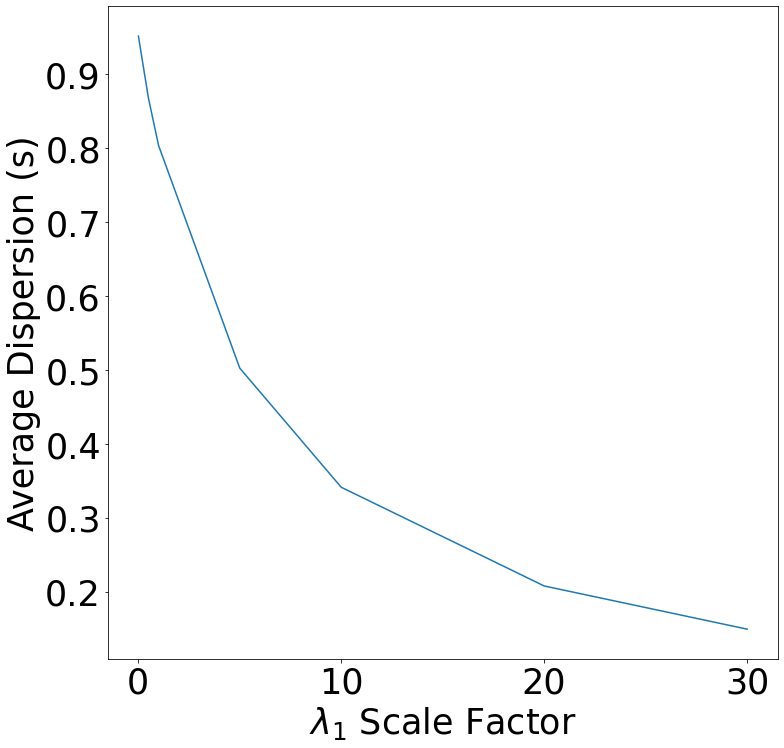

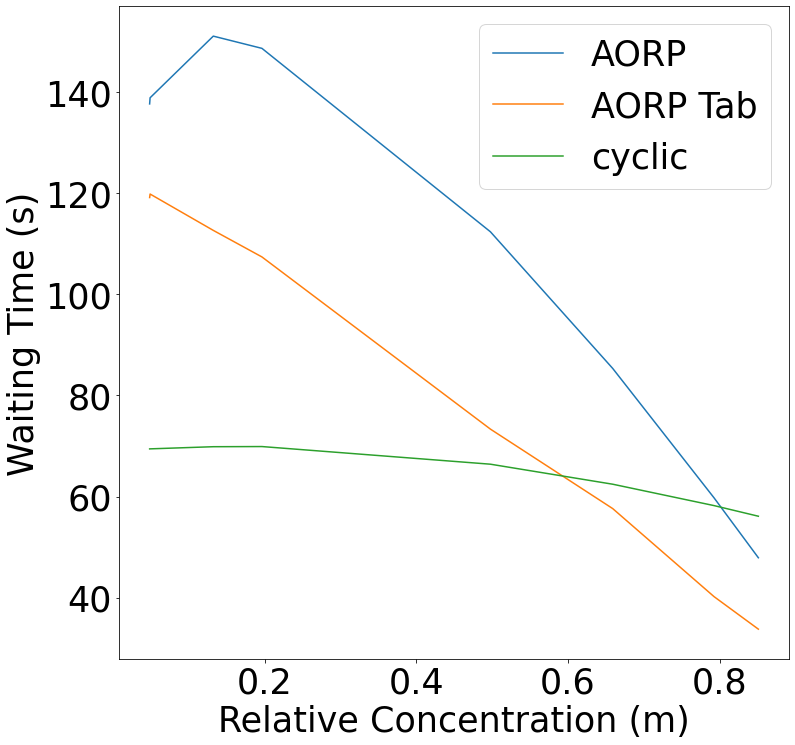

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


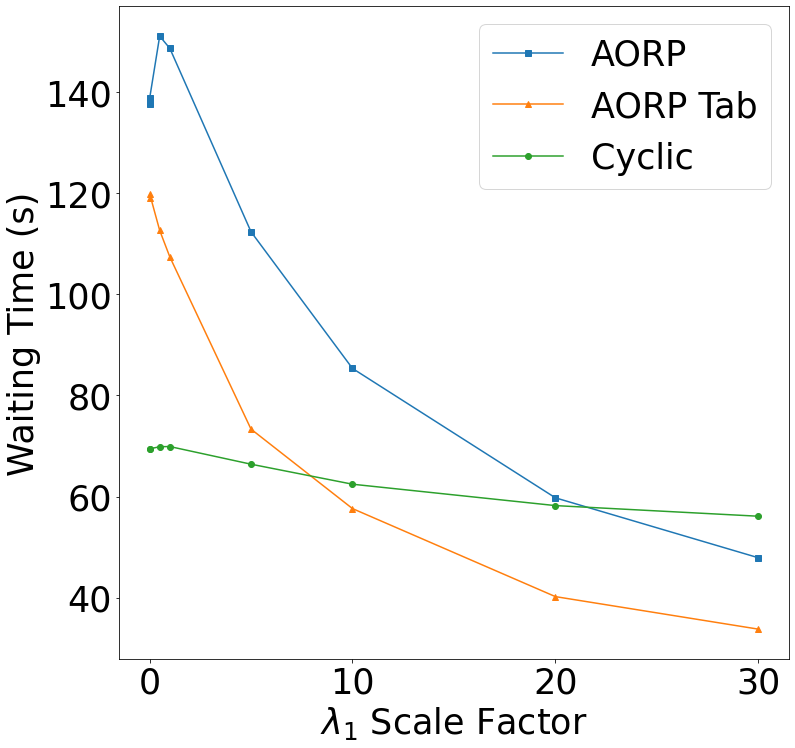

In [47]:
fig = plt.figure(figsize=(12,12))
plt.plot(scales, dispersion)
plt.xlabel("$\\lambda_1$ Scale Factor")
plt.ylabel("Average Dispersion (s)")
plt.show()

dispersion = np.array(dispersion)
conc = 1-dispersion
order = np.argsort(conc).tolist()

fig = plt.figure(figsize=(12,12))
W_aorp = np.array(W_aorp)
plt.plot(conc[order], W_aorp[order], label="AORP")
W_tab = np.array(W_tab)
plt.plot(conc[order], W_tab[order],  label="AORP Tab")
W_tspnp = np.array(W_tspnp)
plt.plot(conc[order], W_tspnp[order], label="cyclic")
plt.xlabel("Relative Concentration (m)")
plt.ylabel("Waiting Time (s)")
plt.legend()
plt.show()

fig = plt.figure(figsize=(12,12))
plt.plot(scales, W_aorp, '-s', label="AORP")
plt.plot(scales, W_tab, '-^', label="AORP Tab")
plt.plot(scales, W_tspnp, '-o', label="Cyclic")
plt.xlabel("$\\lambda_1$ Scale Factor")
plt.ylabel("Waiting Time (s)")
plt.legend()
plt.savefig("star_w_v_scale.png", format='png', bbox_inches='tight')
plt.savefig("star_w_v_scale.eps", format='eps', bbox_inches='tight')
plt.show()